In [ ]:
import numpy as np
import pandas as pd
import os
import scipy
import matplotlib.pyplot as plt
import tensorflow as tf

!pip install python_speech_features

from python_speech_features import logfbank, mfcc, delta
import seaborn as sns
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(1234)
random.seed(1234)
tf.random.set_seed(1234)
!apt-get install tarfile
import tarfile
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import contextlib
import lzma
import tarfile
import matplotlib.pyplot as plt

!pip install visualkeras
import visualkeras

drive.mount('/content/drive')

os.chdir('drive/MyDrive/HDA')

from utilis import *

!tar -xf "speech_recognition.tar.xz" -C "/content"

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=71b935996bac4b07a65d9c2c080ca59767ea112ef638c6f655332e8a556a4f6e
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package tarfile
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 9.9 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
%cd ..
%cd ..
%cd ..
%cd ..

/content/drive/MyDrive
/content/drive
/content
/


**Preliminary Notes**

The code is divided in two blocks:
*   Analysis on standard dataset
*   Analysis on noisy dataset

Since the models are the same for each block, these are defined early in the notebook, as the early stopping criterion.
Each block have the same layout:

*   Model trainig
*   Training and validation curve
*   Model evalutaion on the test
*   Metrics calculation with confusion matrix

NB: all the notebook could be runned sequentially all at once, but I suggest to run it before with standard dataset, then reinitialize the session and run the analysis for noisy dataset, in order to not encounter any ram issue.



In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers, losses
import keras

def CRNN_model(input_dimension, output_shape):

  X_input=keras.Input(input_dimension)

  X=tf.keras.layers.Conv2D(8, kernel_size=(1,3), dilation_rate=(1,2) , padding='same')(X_input)
  X=tf.keras.layers.Activation('relu')(X)
  X=tf.keras.layers.BatchNormalization()(X)

  X=tf.keras.layers.Conv2D(1, kernel_size=(3,3), strides=(1,2) ,padding='same')(X)
  X=tf.keras.layers.Activation('relu')(X)
  X=tf.keras.layers.BatchNormalization()(X)

  X=tf.keras.layers.Dropout(0.2)(X)

  X=tf.keras.layers.Lambda(lambda x:  tf.squeeze(x,-1))(X)

  X=tf.keras.layers.Permute(dims=(2,1))(X)

  X=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True))(X)
  X=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64))(X)

  X=tf.keras.layers.Dense(128, activation='relu')(X)
  X=tf.keras.layers.BatchNormalization()(X)

  X=tf.keras.layers.Dropout(0.3)(X)

  X_final=tf.keras.layers.Dense(output_shape, activation='softmax')(X)

  model = Model(inputs = X_input, outputs = X_final)

  return model

def RNN_base(input_dimension, output_shape):

  X_input=keras.Input(input_dimension)

  X=tf.keras.layers.Lambda(lambda x:  tf.squeeze(x,-1))(X_input)

  X=tf.keras.layers.Permute(dims=(2,1))(X)

  X=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True))(X)
  X=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64))(X)

  X=tf.keras.layers.Dense(128, activation='relu')(X)

  X=tf.keras.layers.Dropout(0.4)(X)

  X_final=tf.keras.layers.Dense(output_shape, activation='softmax')(X)

  model = Model(inputs = X_input, outputs = X_final, name='CRNN_base')

  return model

In [ ]:
# Garbage Collector - use it like gc.collect()
import gc
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import EarlyStopping, Callback

class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, min_delta=0.001)
clear_memory = ClearMemory()

callbacks = [early_stopping, clear_memory]

**Training models with Log FIlterbanks**

In [ ]:
df=pd.DataFrame([(k, i) for k, v in browse_directory().items() for i in v],columns=['key_id', 'ids'])

#train_mask, validation_mask = split(df, 0.6, 0.2)

#df.to_csv("content/drive/MyDrive/HDA/training_validation_test.csv")

train_mask=list(np.loadtxt("content/drive/MyDrive/HDA/training_mask.txt"))
validation_mask=list(np.loadtxt("content/drive/MyDrive/HDA/validation_mask.txt"))

batch_size=128
out_class=len(label_list)

train_set, train_set_label = create_dataset(df['ids'].iloc[train_mask], df['key_id'].iloc[train_mask], batch_size,shuffle=True, cache_file_value='train_cache', type='logfbank')
validation_set, validation_set_label = create_dataset(df['ids'].iloc[validation_mask], df['key_id'].iloc[validation_mask], batch_size, shuffle=True , cache_file_value='validation_cache', type='logfbank')
test_set, test_set_label = create_dataset(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)], df['key_id'].iloc[~df.index.isin(train_mask+validation_mask)], batch_size, cache_file_value='test_cache', shuffle=False  ,repeat=False, type='logfbank', testing=True)

train_steps = int(np.ceil(len(df['ids'].iloc[train_mask]) / batch_size))
validation_steps = int(np.ceil(len(df['ids'].iloc[validation_mask]) / batch_size))
test_steps = int(np.ceil(len(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)]) / batch_size))



Shuffled dataset
Shuffled dataset


In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(40,99,1)

CRNN_m=CRNN_model(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(CRNN_m.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 99, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 40, 99, 8)         32        
                                                                 
 activation (Activation)     (None, 40, 99, 8)         0         
                                                                 
 batch_normalization (Batch  (None, 40, 99, 8)         32        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 50, 1)         73        
                                                                 
 activation_1 (Activation)   (None, 40, 50, 1)         0         
                                                             

In [ ]:
CRNN_m.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_CRNN_m=CRNN_m.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)


Epoch 1/25
497/497 [==============================] - 457s 440ms/step - loss: 2.5477 - sparse_categorical_accuracy: 0.2815 - val_loss: 1.4817 - val_sparse_categorical_accuracy: 0.5868
Epoch 2/25
497/497 [==============================] - 85s 171ms/step - loss: 0.8562 - sparse_categorical_accuracy: 0.7541 - val_loss: 0.5721 - val_sparse_categorical_accuracy: 0.8340
Epoch 3/25
497/497 [==============================] - 83s 167ms/step - loss: 0.5310 - sparse_categorical_accuracy: 0.8462 - val_loss: 0.3811 - val_sparse_categorical_accuracy: 0.8869
Epoch 4/25
497/497 [==============================] - 87s 174ms/step - loss: 0.4333 - sparse_categorical_accuracy: 0.8733 - val_loss: 0.3207 - val_sparse_categorical_accuracy: 0.9045
Epoch 5/25
497/497 [==============================] - 86s 173ms/step - loss: 0.3785 - sparse_categorical_accuracy: 0.8883 - val_loss: 0.3102 - val_sparse_categorical_accuracy: 0.9068
Epoch 6/25
497/497 [==============================] - 83s 168ms/step - loss: 0.3388 

In [ ]:
#CRNN_m.save("content/drive/MyDrive/HDA/models/logf_models/normal_dataset/{}".format('CRNN_log_f'))
CRNN_m=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/logf_models/normal_dataset/{}".format('CRNN_log_f'))

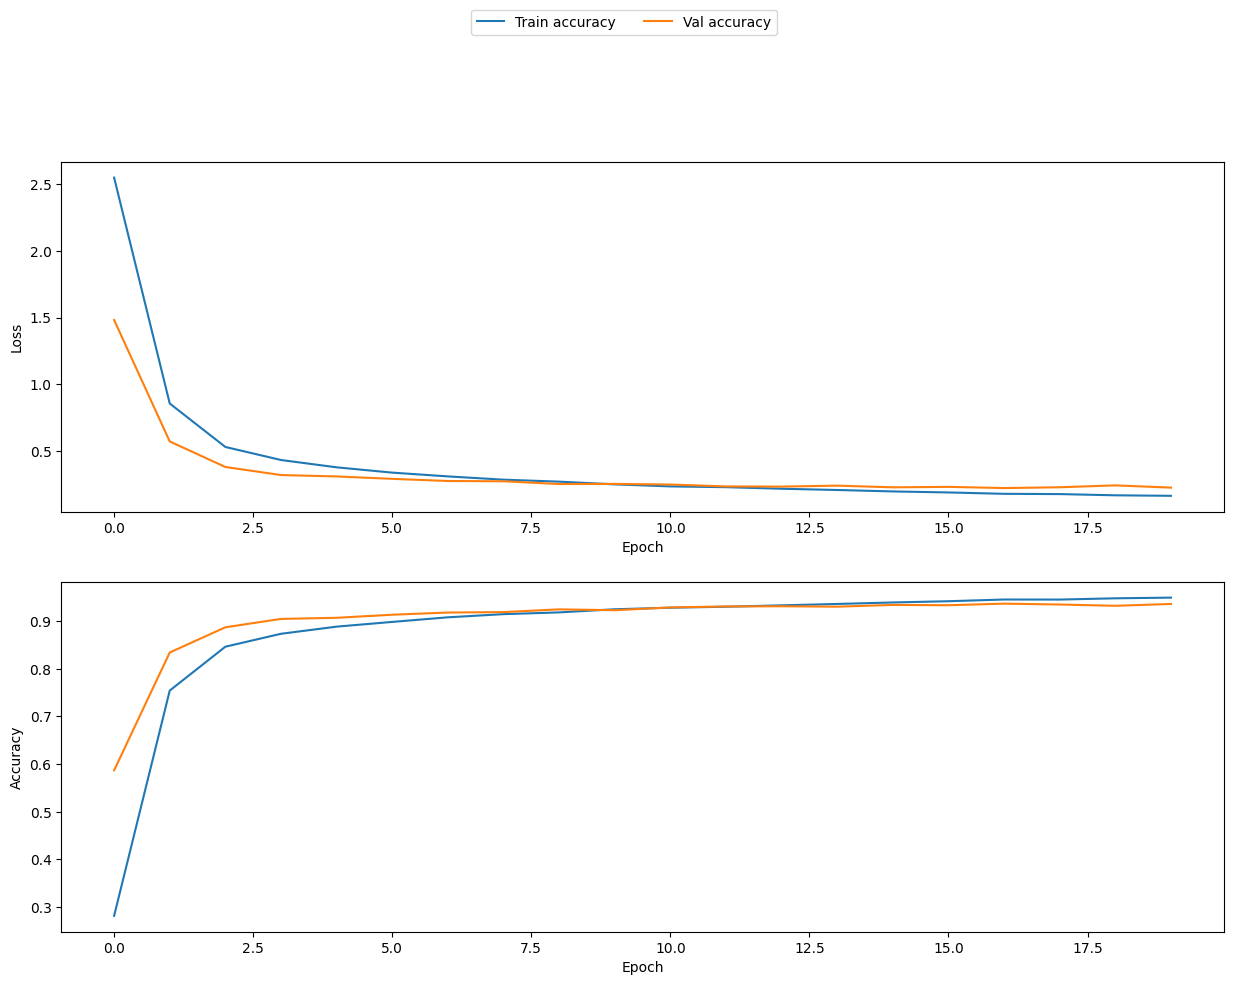

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_CRNN_m.history['loss'], label='Train loss')
axis[0].plot(history_CRNN_m.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_CRNN_m.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_CRNN_m.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score


perform={}

perform["accuracy"]=[]
perform["balanced_accuracy"]=[]

perform["f1_score_weighted"]=[]
perform["f1_score_micro"]=[]
perform["f1_score_macro"]=[]

perform["precision_score_weighted"]=[]
perform["precision_score_micro"]=[]
perform["precision_score_macro"]=[]

perform["recall_score_weighted"]=[]
perform["recall_score_micro"]=[]
perform["recall_score_macro"]=[]
perform['model']=[]

pred=CRNN_m.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{CRNN_m=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))


166/166 [==============================] - 85s 513ms/step


In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.932678,0.925592,0.932656,0.932678,0.926101,0.933213,0.932678,0.927259,0.932678,0.932678,0.925592,CRNN_m


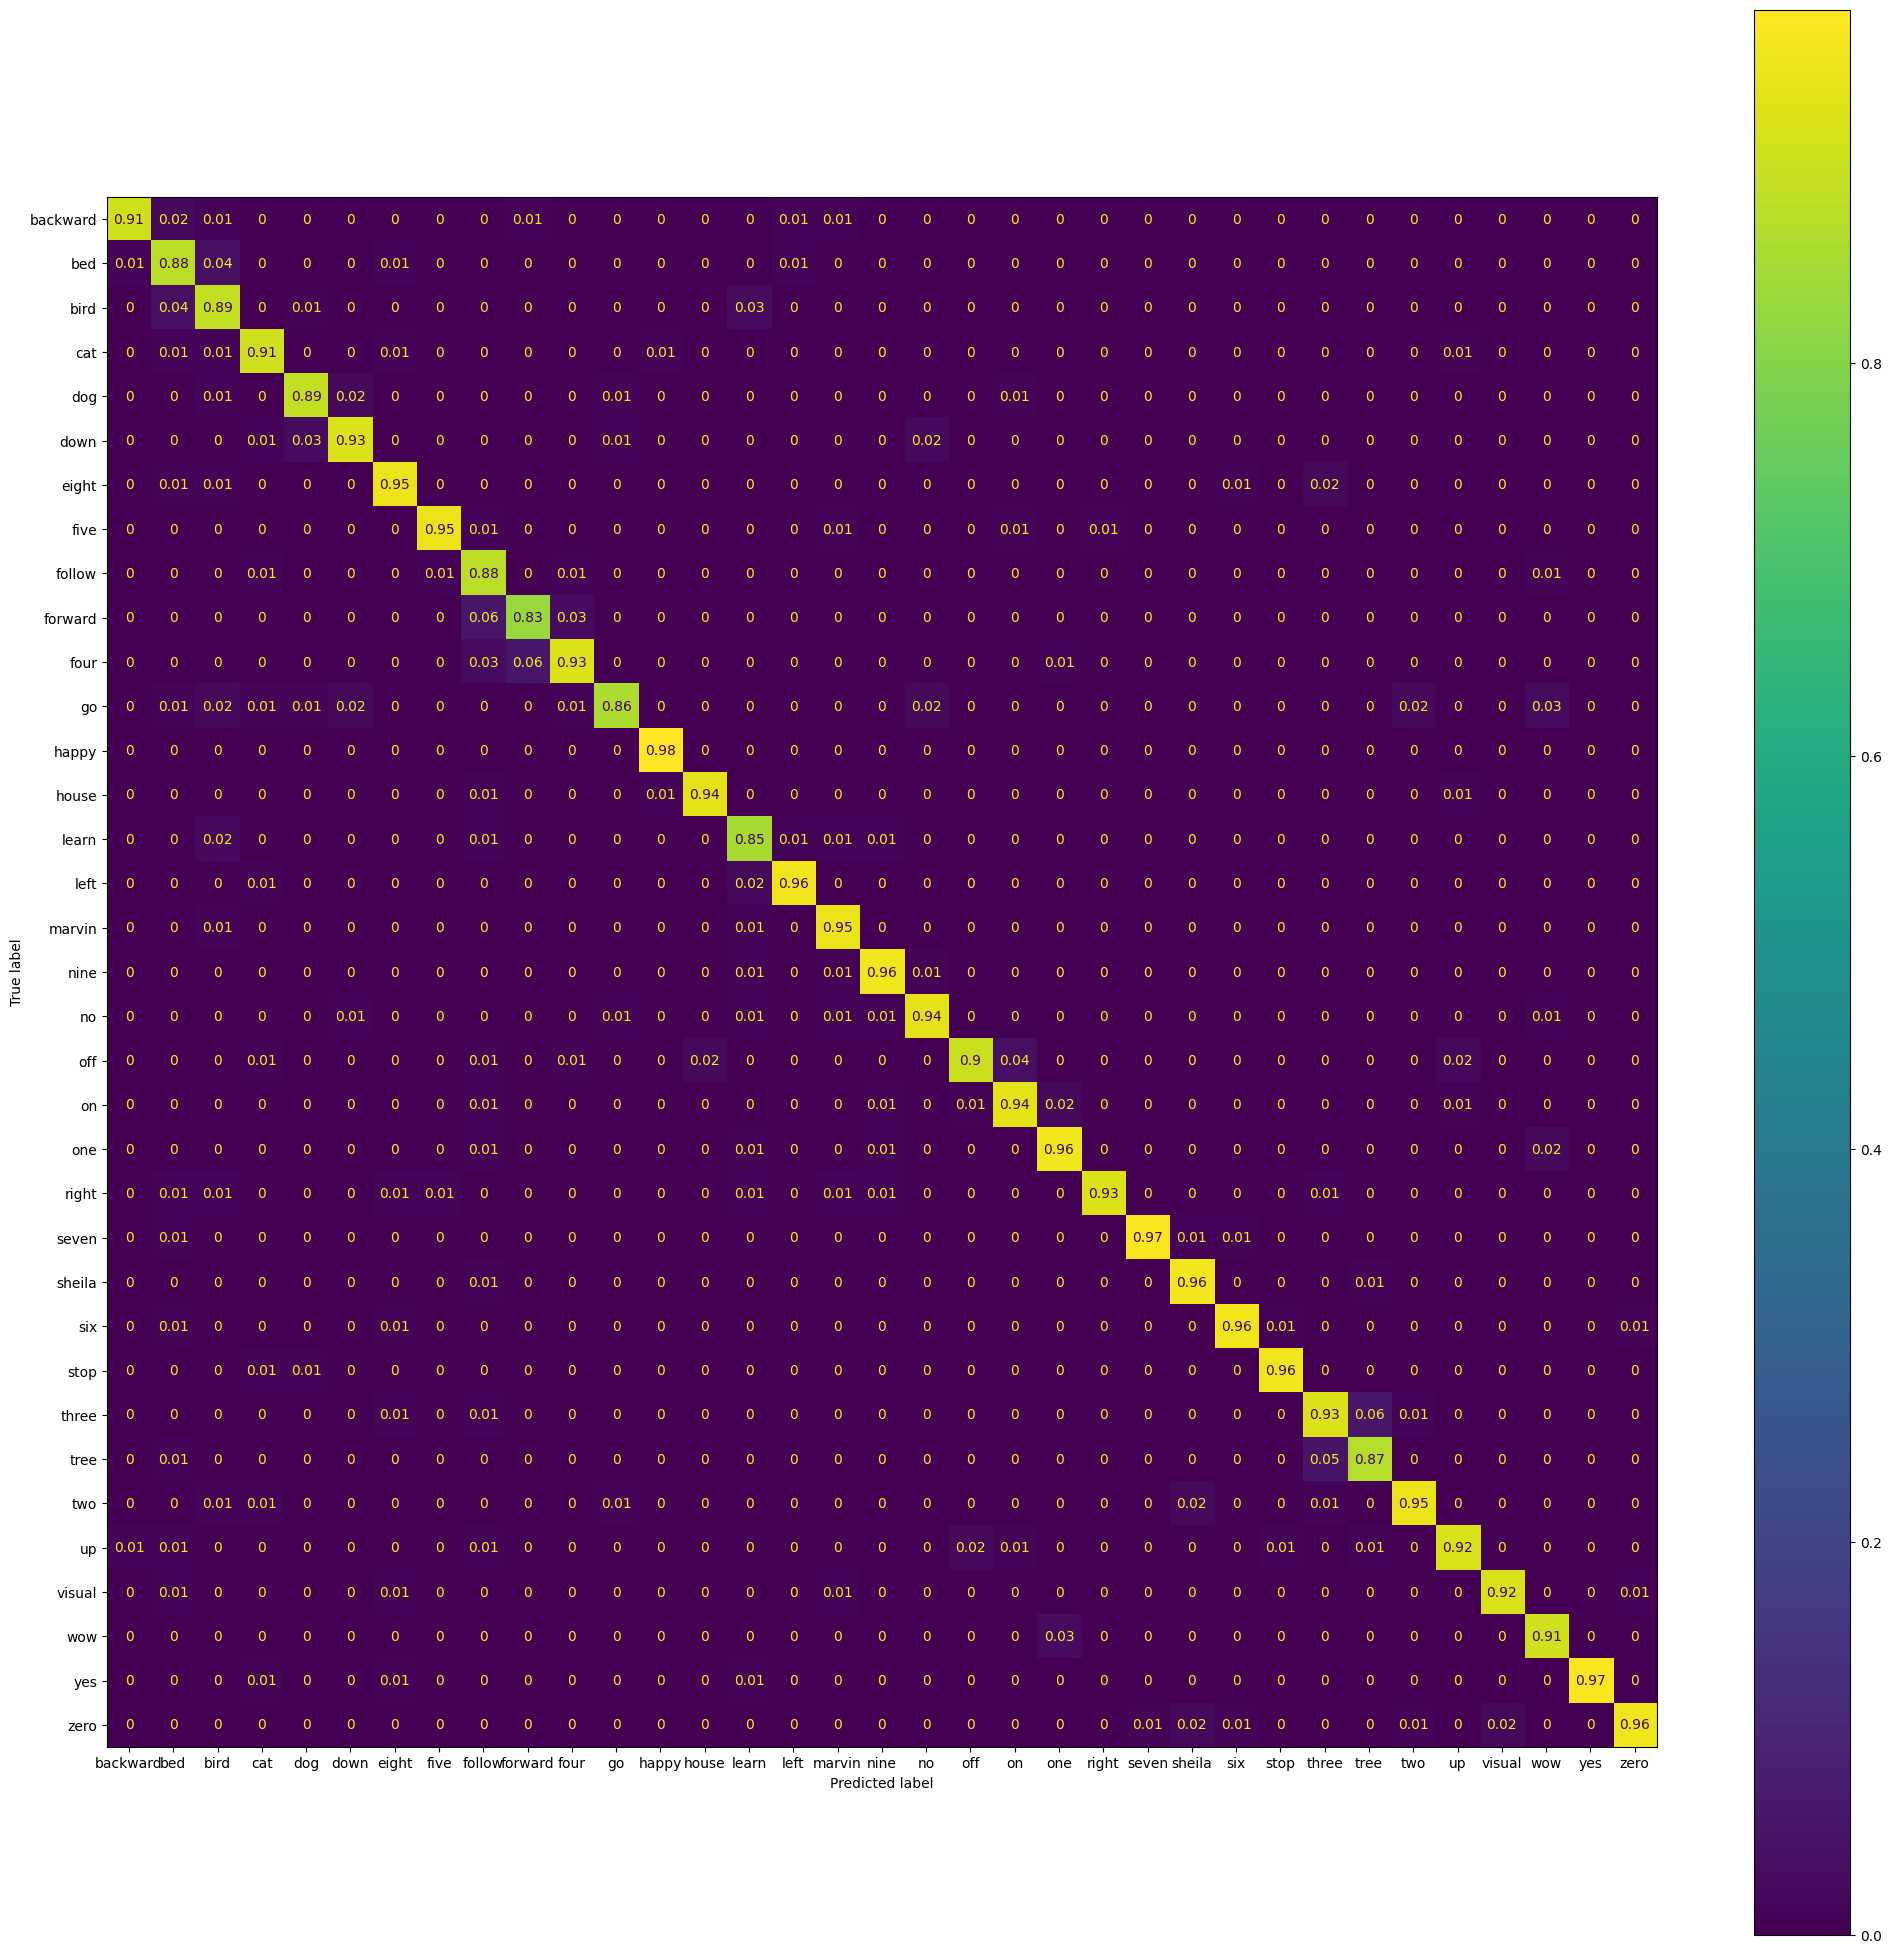

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(40,99,1)

RNN_base=RNN_base(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(RNN_base.summary())

Model: "CRNN_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 99, 1)]       0         
                                                                 
 lambda (Lambda)             (None, 40, 99)            0         
                                                                 
 permute (Permute)           (None, 99, 40)            0         
                                                                 
 bidirectional (Bidirection  (None, 99, 128)           40704     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               74496     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 128)               16

In [ ]:
RNN_base.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_RNN_base=RNN_base.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)


Epoch 1/25
497/497 [==============================] - 63s 125ms/step - loss: 1.9179 - sparse_categorical_accuracy: 0.4434 - val_loss: 0.9355 - val_sparse_categorical_accuracy: 0.7181
Epoch 2/25
497/497 [==============================] - 68s 136ms/step - loss: 0.8772 - sparse_categorical_accuracy: 0.7413 - val_loss: 0.6407 - val_sparse_categorical_accuracy: 0.8045
Epoch 3/25
497/497 [==============================] - 67s 135ms/step - loss: 0.6705 - sparse_categorical_accuracy: 0.8024 - val_loss: 0.5238 - val_sparse_categorical_accuracy: 0.8409
Epoch 4/25
497/497 [==============================] - 67s 134ms/step - loss: 0.5691 - sparse_categorical_accuracy: 0.8325 - val_loss: 0.4858 - val_sparse_categorical_accuracy: 0.8518
Epoch 5/25
497/497 [==============================] - 64s 129ms/step - loss: 0.4932 - sparse_categorical_accuracy: 0.8543 - val_loss: 0.4127 - val_sparse_categorical_accuracy: 0.8739
Epoch 6/25
497/497 [==============================] - 63s 127ms/step - loss: 0.4508 -

In [ ]:
RNN_base.save("content/drive/MyDrive/HDA/models/logf_models/normal_dataset/{}".format('RNN_base_log_f'))
#RNN_base=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/logf_models/normal_dataset/{}".format('RNN_base_log_f'))

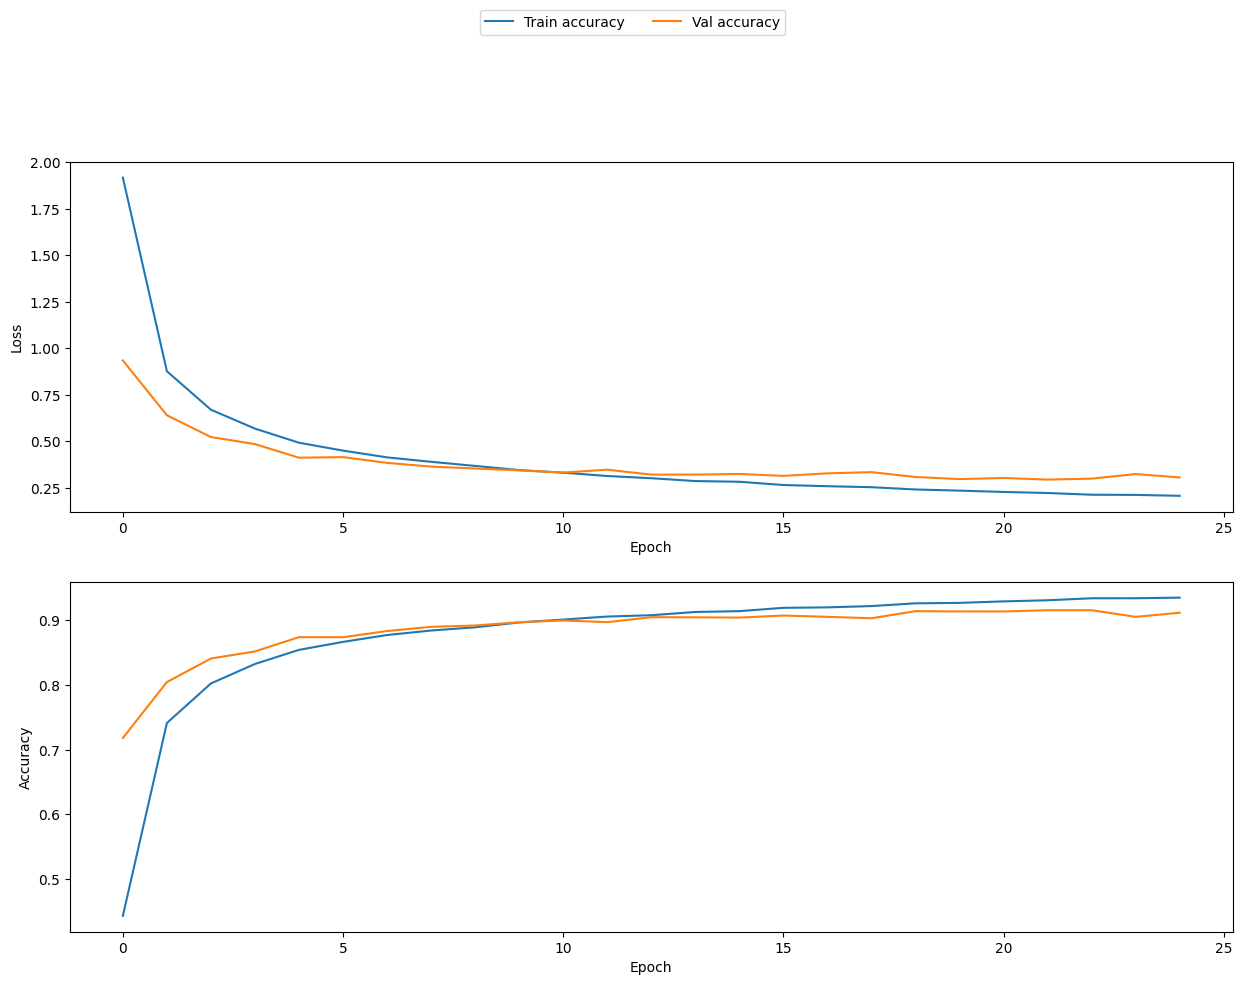

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_RNN_base.history['loss'], label='Train loss')
axis[0].plot(history_RNN_base.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_RNN_base.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_RNN_base.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score


pred=RNN_base.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{RNN_base=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))



166/166 [==============================] - 5s 30ms/step


In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.932678,0.925592,0.932656,0.932678,0.926101,0.933213,0.932678,0.927259,0.932678,0.932678,0.925592,CRNN_m
1,0.917608,0.907757,0.917572,0.917608,0.910521,0.918966,0.917608,0.915352,0.917608,0.917608,0.907757,RNN_base


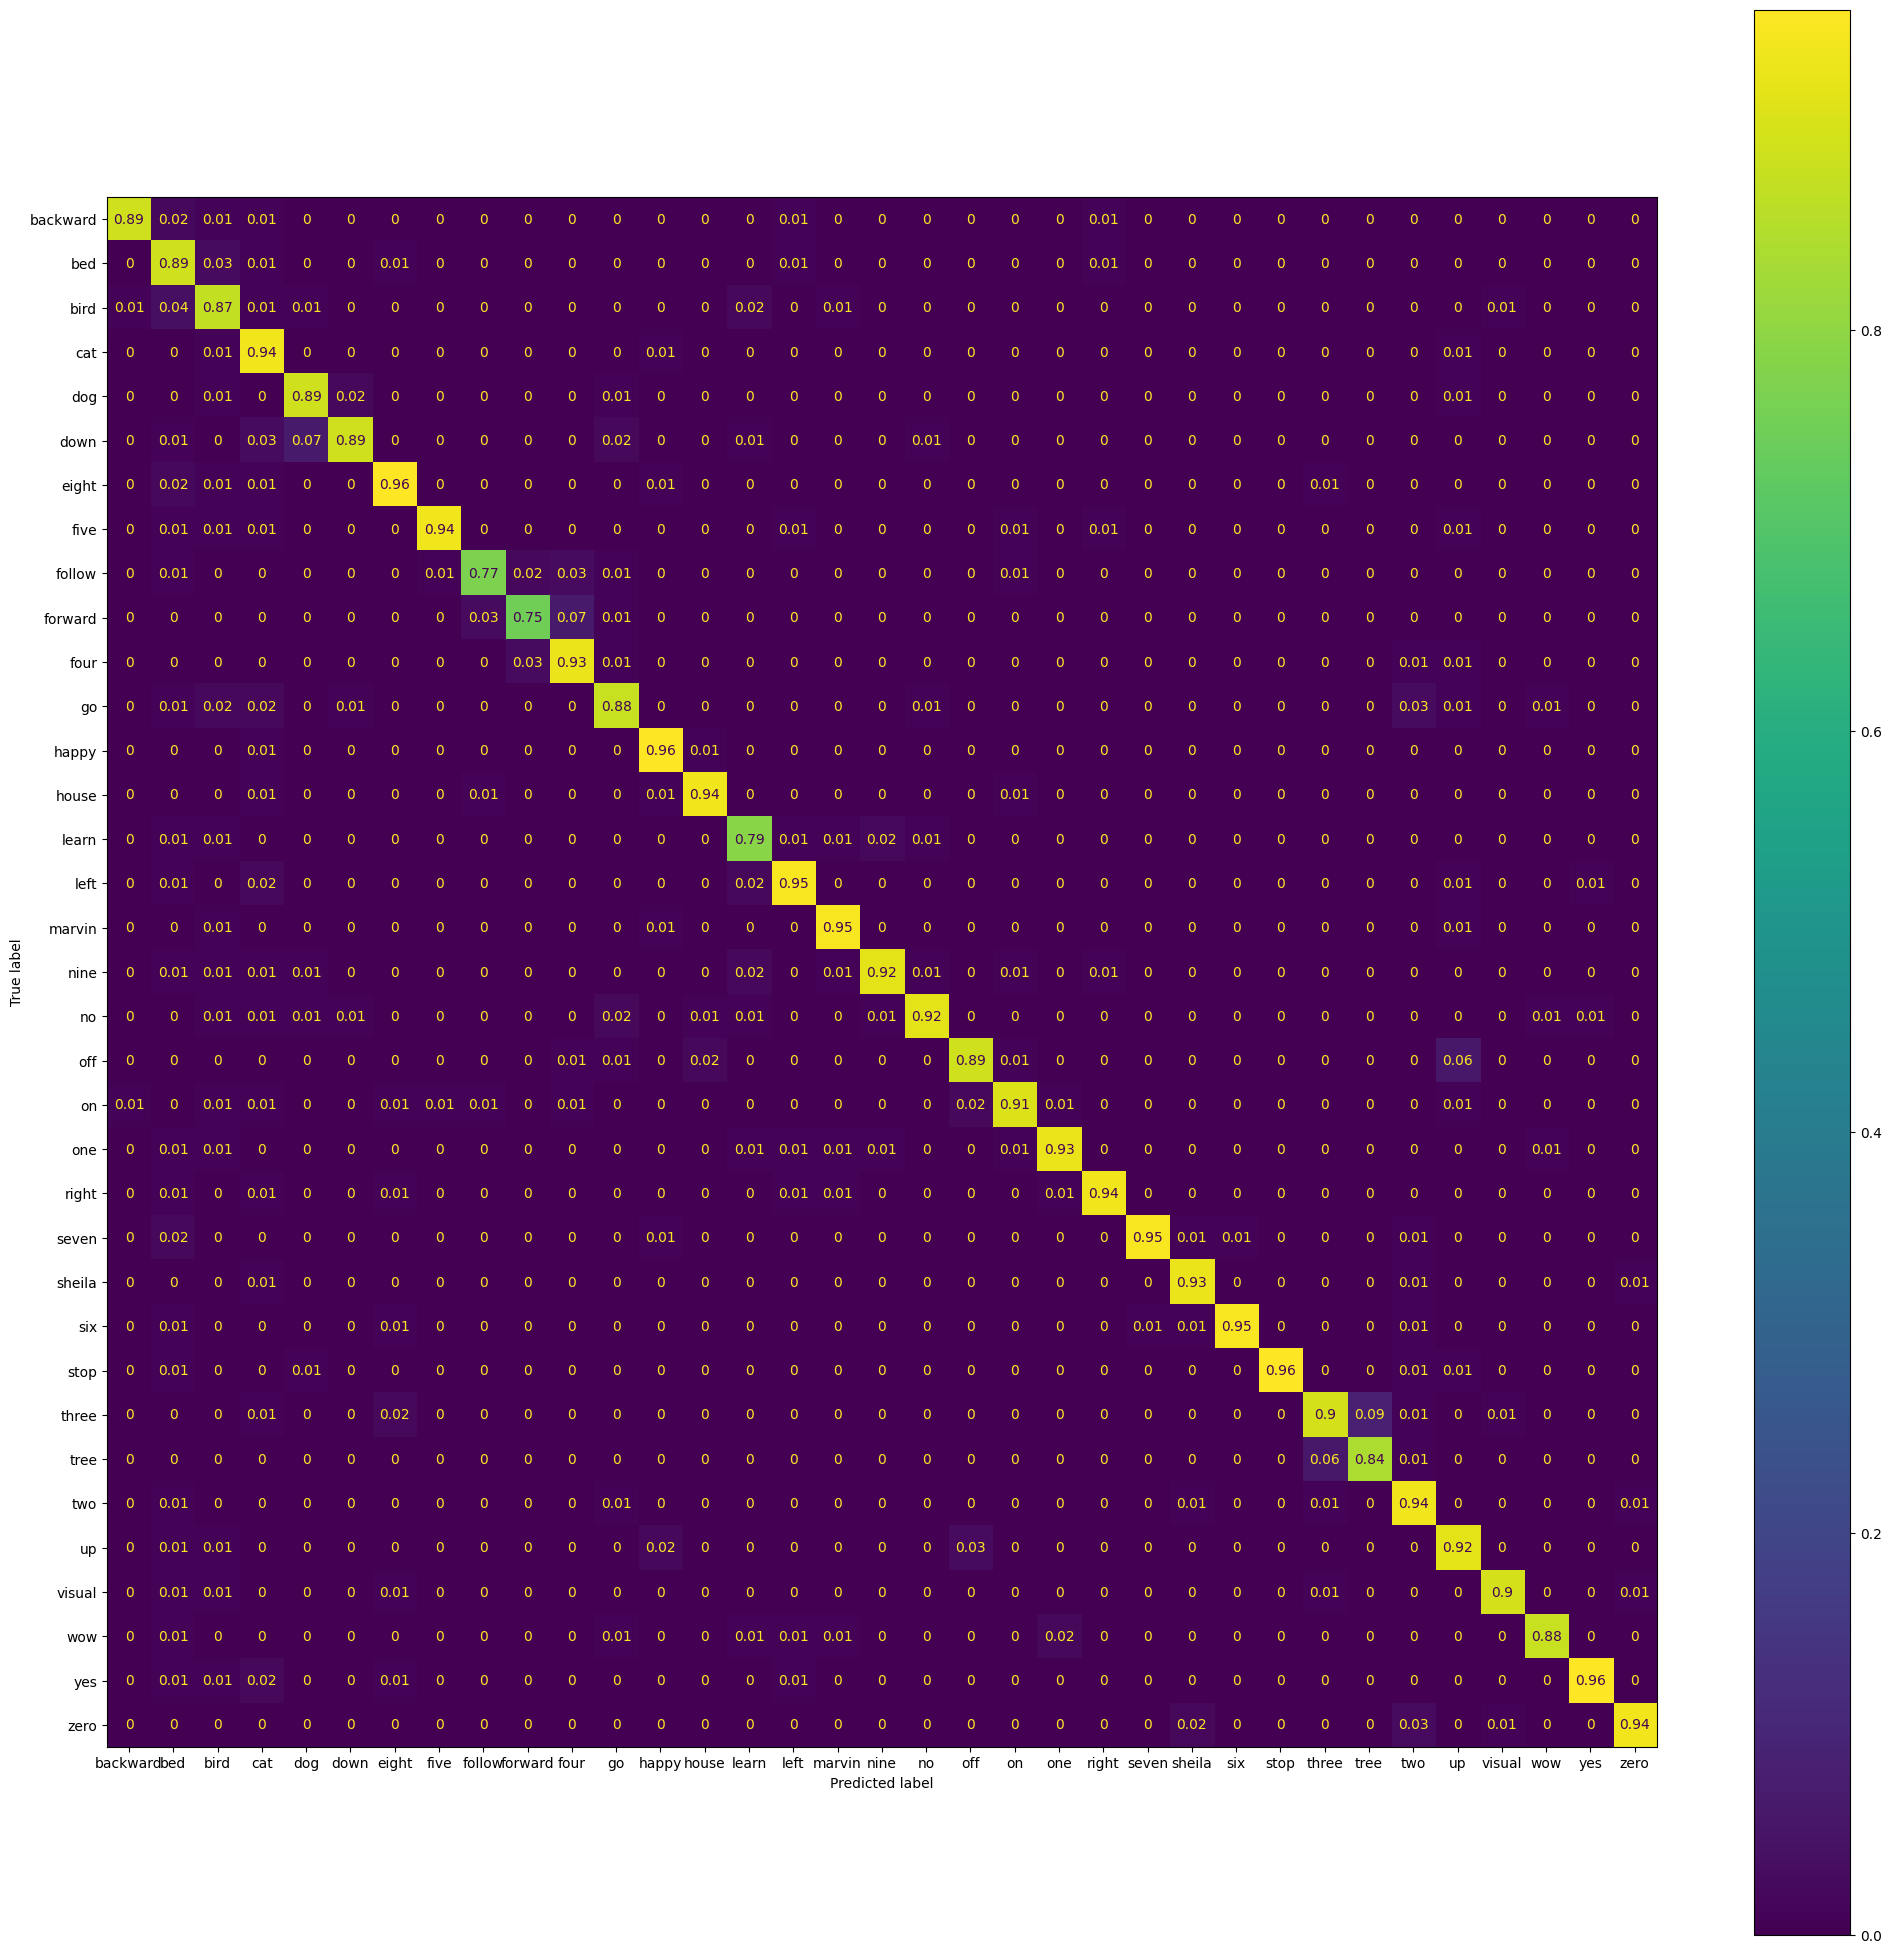

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.932631,0.926032,0.932593,0.932631,0.928202,0.933125,0.932631,0.931074,0.932631,0.932631,0.926032,CRNN_m
1,0.917702,0.912062,0.917925,0.917702,0.911092,0.919054,0.917702,0.911359,0.917702,0.917702,0.912062,RNN_base


**Training Models on noised Log Filterbanks**

In [ ]:
del perform, train_set, train_set_label, validation_set, validation_set_label, test_set, test_set_label,
del history_RNN_base, RNN_base, CRNN_m, history_CRNN_m

tf.keras.backend.clear_session()
gc.collect()


In [ ]:
df=pd.DataFrame([(k, i) for k, v in browse_directory().items() for i in v],columns=['key_id', 'ids'])

train_mask, validation_mask = split(df, 0.6, 0.20)

batch_size=128
out_class=len(label_list)

train_set, train_set_label = create_dataset(df['ids'].iloc[train_mask], df['key_id'].iloc[train_mask], batch_size,shuffle=True, cache_file_value='train_cache', type='logfbank', input_noise=True)
validation_set, validation_set_label = create_dataset(df['ids'].iloc[validation_mask], df['key_id'].iloc[validation_mask], batch_size, shuffle=True , cache_file_value='validation_cache', type='logfbank', input_noise=True)
test_set, test_set_label = create_dataset(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)], df['key_id'].iloc[~df.index.isin(train_mask+validation_mask)], batch_size, cache_file_value='test_cache', shuffle=False  ,repeat=False, type='logfbank', testing=True, input_noise=True)

train_steps = int(np.ceil(len(df['ids'].iloc[train_mask]) / batch_size))
validation_steps = int(np.ceil(len(df['ids'].iloc[validation_mask]) / batch_size))
test_steps = int(np.ceil(len(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)]) / batch_size))



Shuffled dataset
Shuffled dataset


In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(40,99,1)

CRNN_m=CRNN_model(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(CRNN_m.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 99, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 40, 99, 8)         32        
                                                                 
 activation (Activation)     (None, 40, 99, 8)         0         
                                                                 
 batch_normalization (Batch  (None, 40, 99, 8)         32        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 50, 1)         73        
                                                                 
 activation_1 (Activation)   (None, 40, 50, 1)         0         
                                                             

In [ ]:
CRNN_m.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_CRNN_m=CRNN_m.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)


Epoch 1/25
497/497 [==============================] - 460s 351ms/step - loss: 2.6688 - sparse_categorical_accuracy: 0.2442 - val_loss: 3.3721 - val_sparse_categorical_accuracy: 0.1542
Epoch 2/25
497/497 [==============================] - 88s 176ms/step - loss: 1.5008 - sparse_categorical_accuracy: 0.5559 - val_loss: 1.2464 - val_sparse_categorical_accuracy: 0.6199
Epoch 3/25
497/497 [==============================] - 86s 173ms/step - loss: 1.1690 - sparse_categorical_accuracy: 0.6520 - val_loss: 0.8895 - val_sparse_categorical_accuracy: 0.7315
Epoch 4/25
497/497 [==============================] - 85s 171ms/step - loss: 1.0047 - sparse_categorical_accuracy: 0.7010 - val_loss: 0.8846 - val_sparse_categorical_accuracy: 0.7315
Epoch 5/25
497/497 [==============================] - 85s 171ms/step - loss: 0.9112 - sparse_categorical_accuracy: 0.7295 - val_loss: 1.2730 - val_sparse_categorical_accuracy: 0.6386
Epoch 6/25
497/497 [==============================] - 86s 173ms/step - loss: 0.8413 

In [ ]:
CRNN_m.save("content/drive/MyDrive/HDA/models/logf_models/noisy_dataset/{}".format('CRNN_log_f_noise'))
#mix_CNN_flog=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/{}".format('CRNN_log_f'))

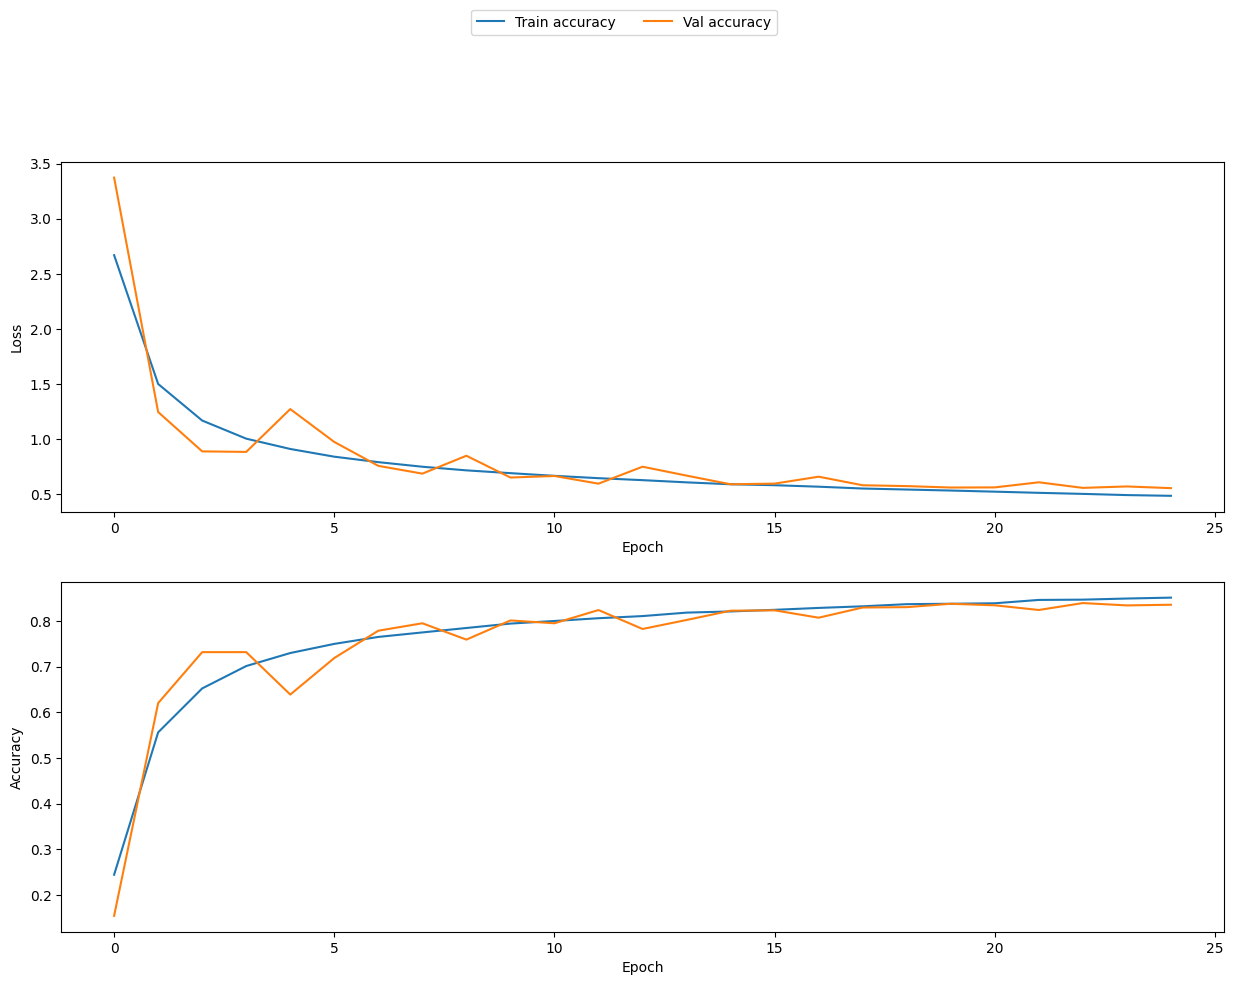

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_CRNN_m.history['loss'], label='Train loss')
axis[0].plot(history_CRNN_m.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_CRNN_m.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_CRNN_m.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score

perform={}

perform["accuracy"]=[]
perform["balanced_accuracy"]=[]

perform["f1_score_weighted"]=[]
perform["f1_score_micro"]=[]
perform["f1_score_macro"]=[]

perform["precision_score_weighted"]=[]
perform["precision_score_micro"]=[]
perform["precision_score_macro"]=[]

perform["recall_score_weighted"]=[]
perform["recall_score_micro"]=[]
perform["recall_score_macro"]=[]
perform['model']=[]

pred=CRNN_m.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{CRNN_m=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))



166/166 [==============================] - 105s 633ms/step


In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.841073,0.830954,0.841879,0.841073,0.837235,0.848097,0.841073,0.849221,0.841073,0.841073,0.830954,CRNN_m


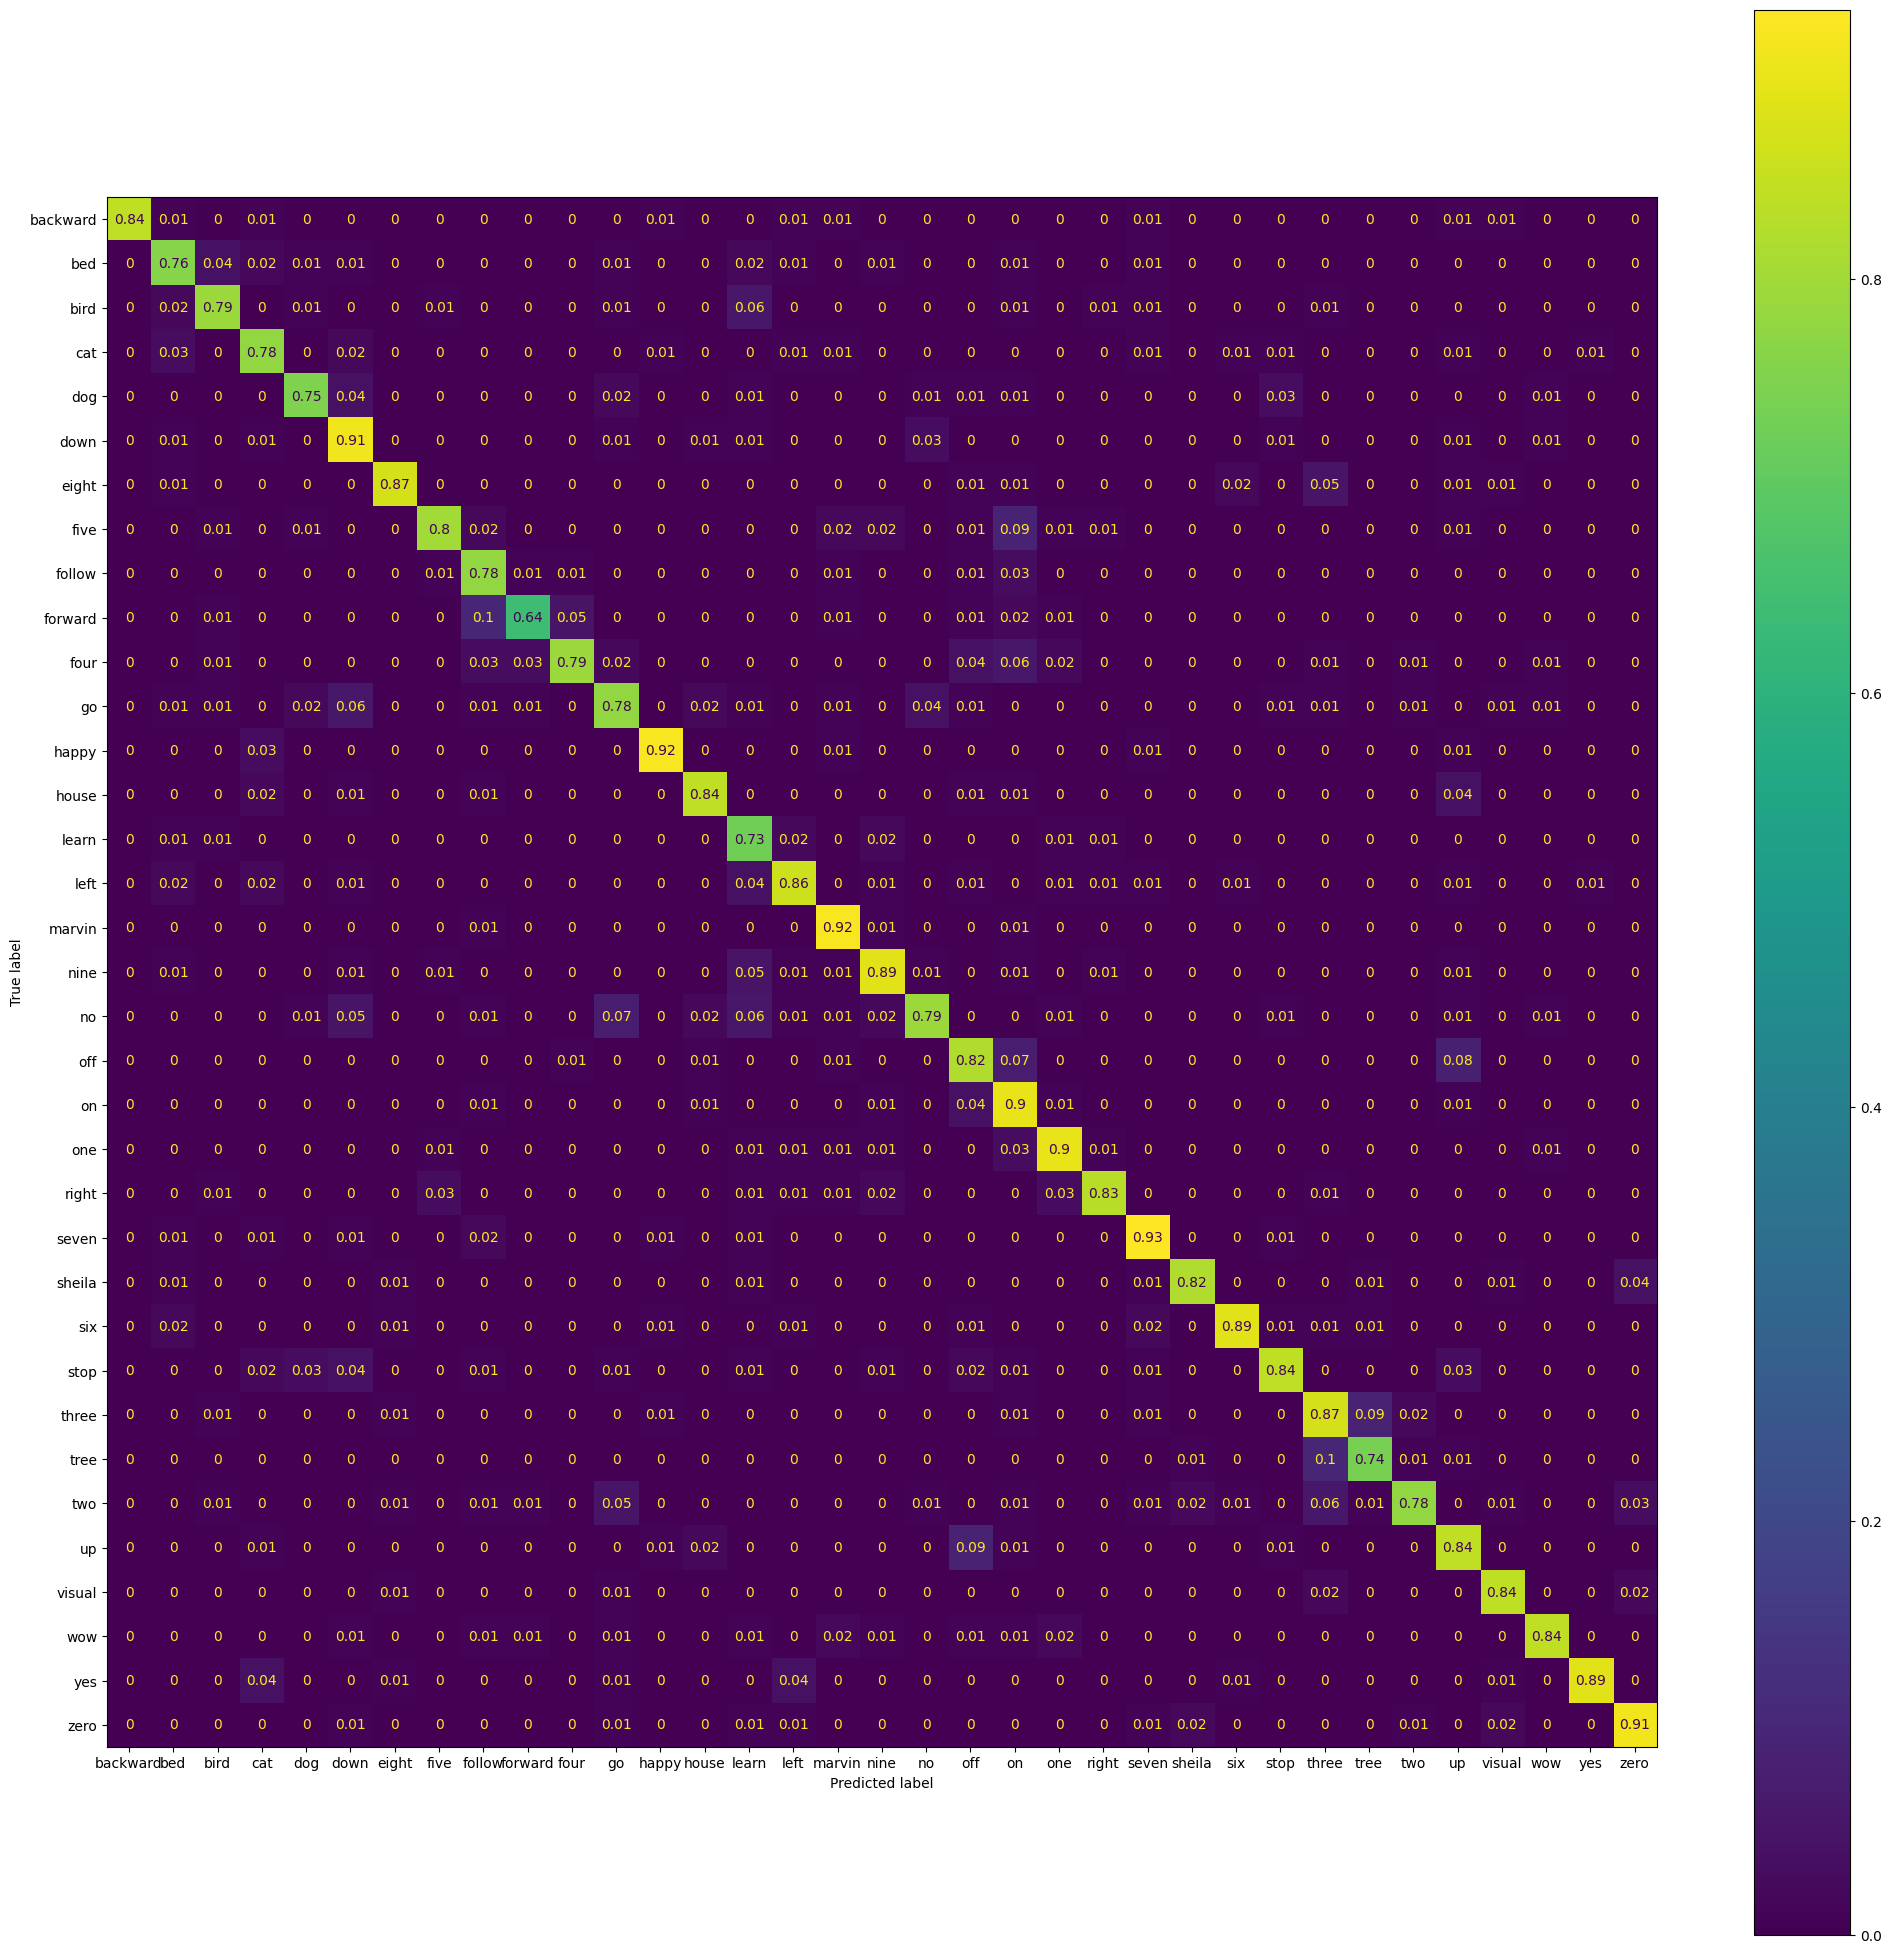

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

In [ ]:
tf.keras.backend.clear_session()
gc.collect()


264

In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(40,99,1)

RNN_base=RNN_base(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(RNN_base.summary())

Model: "CRNN_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 99, 1)]       0         
                                                                 
 lambda (Lambda)             (None, 40, 99)            0         
                                                                 
 permute (Permute)           (None, 99, 40)            0         
                                                                 
 bidirectional (Bidirection  (None, 99, 128)           40704     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               74496     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 128)               16

In [ ]:
RNN_base.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_RNN_base=RNN_base.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)


Epoch 1/25
497/497 [==============================] - 65s 130ms/step - loss: 2.9167 - sparse_categorical_accuracy: 0.1615 - val_loss: 1.8735 - val_sparse_categorical_accuracy: 0.4343
Epoch 2/25
497/497 [==============================] - 67s 135ms/step - loss: 1.6502 - sparse_categorical_accuracy: 0.5009 - val_loss: 1.2511 - val_sparse_categorical_accuracy: 0.6210
Epoch 3/25
497/497 [==============================] - 67s 135ms/step - loss: 1.2005 - sparse_categorical_accuracy: 0.6394 - val_loss: 1.0184 - val_sparse_categorical_accuracy: 0.6899
Epoch 4/25
497/497 [==============================] - 67s 135ms/step - loss: 1.0186 - sparse_categorical_accuracy: 0.6962 - val_loss: 0.8809 - val_sparse_categorical_accuracy: 0.7319
Epoch 5/25
497/497 [==============================] - 67s 135ms/step - loss: 0.9128 - sparse_categorical_accuracy: 0.7287 - val_loss: 0.8270 - val_sparse_categorical_accuracy: 0.7472
Epoch 6/25
497/497 [==============================] - 67s 135ms/step - loss: 0.8359 -

In [ ]:
gc.collect()

696

In [ ]:
RNN_base.save("content/drive/MyDrive/HDA/models/logf_models/noisy_dataset/{}".format('RNN_base_log_f_noisy'))
#mix_CNN_flog=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/{}".format('CRNN_log_f'))

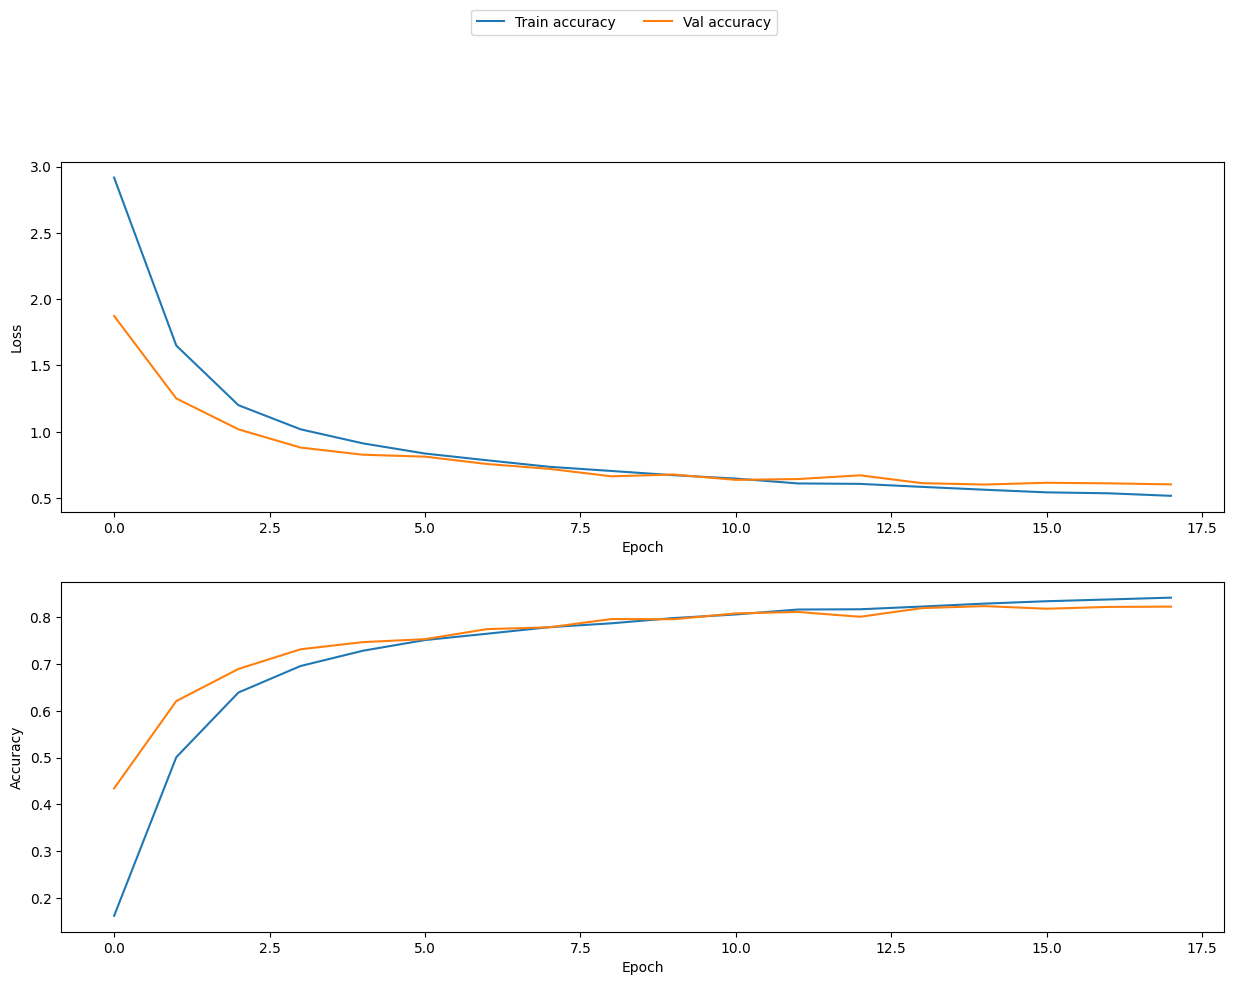

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_RNN_base.history['loss'], label='Train loss')
axis[0].plot(history_RNN_base.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_RNN_base.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_RNN_base.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score


pred=RNN_base.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{RNN_base=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))



166/166 [==============================] - 5s 30ms/step


In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.841073,0.830954,0.841879,0.841073,0.837235,0.848097,0.841073,0.849221,0.841073,0.841073,0.830954,CRNN_m
1,0.822223,0.811587,0.822591,0.822223,0.814993,0.827363,0.822223,0.824189,0.822223,0.822223,0.811587,RNN_base
